# A/B тест для крупного интернет-магазина

Нам предстоит проанализировать данные для крупного интернет-магазина. Вместе с отделом маркетинга мы разработали список гипотез для увеличения выручки. Необходимо <b>приоритизировать гипотезы</b>, запустить <b>A/B тест</b>, <b>проанализировать результаты</b> и <b>принять решение</b> о дальнейших действиях на основе проведенного анализа. Разделим данные исследование на несколько шагов:

## <a href='#section0'>0. Загрузка библиотек</a><br>
## <a href='#section1'>1. Приоритизация гипотез</a><br>
### <a href='#section10'>1.0 Импорт и предобработка файла</a><br>
### <a href='#section11'>1.1 Фреймворк ICE</a><br>
### <a href='#section12'>1.2 Фреймворк RICE</a><br>
## <a href='#section2'>2. Анализ A/B теста</a><br>
### <a href='#section20'>2.0. Импорт и предобработка файлов</a><br>
### <a href='#section21'>2.1. Кумулятивная выручка по группам</a><br>
### <a href='#section22'>2.2. Кумулятивный средний чек по группам</a><br>
### <a href='#section23'>2.3. Кумулятивная конверсия по группам</a><br>
### <a href='#section24'>2.4. Выбор границы для определения аномальных пользователей</a><br>
### <a href='#section25'>2.5. Выбор границы для определения аномальных заказов</a><br>
### <a href='#section26'>2.6. Различия в конверсии между группами по «сырым» данным</a><br>
### <a href='#section27'>2.7. Различия в среднем чеке заказа между группами по «сырым» данным</a><br>
### <a href='#section28'>2.8. Различия в конверсии между группами по «очищенным» данным</a><br>
### <a href='#section29'>2.9. Различия в среднем чеке заказа между группами по «очищенным» данным</a><br>
## <a href='#section3'>3. Принятие решения по итогам A/B теста</a><br>

## <a id='section0'>0. Загрузка библиотек</a><br>

In [1]:
#Импортируем библиотеки
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#Выберем стили графиков
large = 16; med = 12; small = 10
params = {'axes.titlesize': med,
          'axes.titleweight': 'light',
          'axes.labelweight': 'light',
          'legend.fontsize': small,
          'figure.figsize': (12, 6),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
sns.set_style('darkgrid')

---

## <a id='section1'>1. Приоритизация гипотез</a><br>

### <a id='section10'>1.0 Импорт и предобработка файла</a><br>

In [2]:
#Импортируем файл с гипотезами
hypothesis = pd.read_csv('hypothesis.csv')
#Назначаем имя датафрейма
hypothesis.name = 'hypothesis'
#Проверим данные на пропуски и аномалии
def check_dataframe(dataframe):
    print('Проверяем датафрейм:', dataframe.name)
    display(dataframe.head(10))
    display(dataframe.describe())
    display(dataframe.info())
    display(dataframe.duplicated().unique())
check_dataframe(hypothesis)

Проверяем датафрейм: hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

array([False])

В данных нет явных пропусков, ошибок, аномалий и дубликатов.

In [3]:
#Настроим датафрейм так, чтобы гипотезы отобажались полностью
pd.set_option('max_colwidth', 400)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### <a id='section11'>1.1 Фреймворк ICE</a><br>

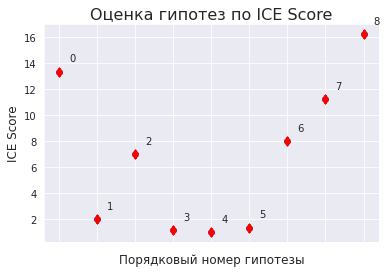

In [4]:
#Находим значение ICE Score по формуле Impact * Confidence / Efforts и отсортируем имеющиеся гипотезы
hypothesis['ICE_Score'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
#Нарисуем график оценки гипотез по ICE Score
x = pd.Series(range(0, len(hypothesis['ICE_Score'])))
y = hypothesis['ICE_Score'].values
types =  hypothesis.index
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Порядковый номер гипотезы')
ax.set_ylabel('ICE Score')
ax.set_title('Оценка гипотез по ICE Score')
ax.set_xticklabels([])
for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker="d", color='r')

Наилучший результат - у гипотезы 8

In [5]:
print('Гипотеза 8:', hypothesis.iloc[8,0])
print('Оценка ICE Score:', hypothesis.iloc[8,5])

Гипотеза 8: Запустить акцию, дающую скидку на товар в день рождения
Оценка ICE Score: 16.2


Согласно фреймворку ICE, в первую очередь подлежит проверки Гипотеза № 8: "Запустить акцию, дающую скидку на товар в день рождения" с оценкой ICE Score 16.2

### <a id='section12'>1.2 Фреймворк RICE</a><br>

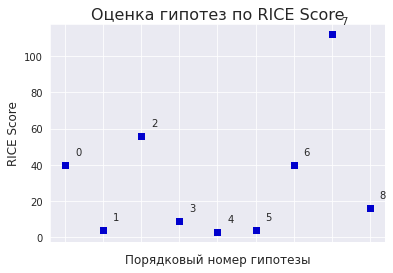

In [6]:
#Находим значение RICE Score по формуле Reach * Impact * Confidence / Efforts и отсортируем имеющиеся гипотезы
hypothesis['RICE_Score'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/ hypothesis['Efforts']
#Нарисуем график оценки гипотез по RICE Score
x = pd.Series(range(0, len(hypothesis['RICE_Score'])))
y = hypothesis['RICE_Score'].values
types =  hypothesis.index
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Порядковый номер гипотезы')
ax.set_ylabel('RICE Score')
ax.set_title('Оценка гипотез по RICE Score')
ax.set_xticklabels([])
for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker="s", color='mediumblue')

Наилучший результат - у гипотезы 7

In [7]:
print('Гипотеза 7:', hypothesis.iloc[7,0])
print('Оценка RICE Score:', hypothesis.iloc[7,6])

Гипотеза 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Оценка RICE Score: 112.0


Согласно фреймворку RICE, в первую очередь подлежит проверке Гипотеза № 7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" с оценкой RICE Score 112.

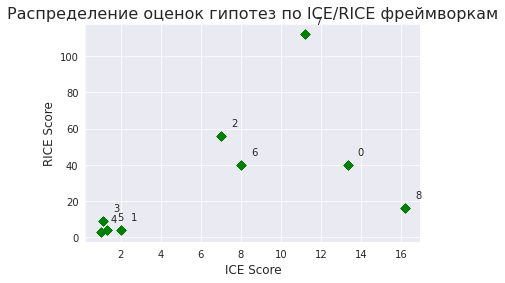

In [8]:
#Посмотрим, как распределятся оценки гипотез по ICE/RICE фреймворкам на одном графике
x = hypothesis['ICE_Score'].values
y = hypothesis['RICE_Score'].values
types =  hypothesis.index
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('ICE Score')
ax.set_ylabel('RICE Score')
ax.set_title('Распределение оценок гипотез по ICE/RICE фреймворкам')
for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker="D", color='g')

Появился еще один лидер: оценка гипотезы 0 превосходит оценку гипотезы 7 по фреймворку ICE. Но, как и гипотеза 8, уступает в фреймворке RICE.

In [9]:
print('Гипотеза 0:', hypothesis.iloc[0,0])

Гипотеза 0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


#### Вывод
Фреймворк RICE в отличие от ICE учитывает в т.ч. охват пользователей для теста. Для нас он будет приоритетным. Так, скидка на товар в день рождения - это очень ограниченная акция. Проверка такой гипотезы может потребовать более длительного времени, поскольку в среднем ежедневно только 1/365 от всех пользователей могут участвовать в этом тесте. Если учесть, что не все пользователи увидят сообщения об акции, а те которые увидят и примут участие будут разделены на контрольную и тестовую группу, то пользователей будет еще меньше. Если же тест будет слишком продолжительным, на него могут повлиять макроэкономические факторы, сезонность и действия конкурентов. Для проведения нашего A/B теста остановимся на гипотезе с максимальным RICE Score: Гипотеза № 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

---

## <a id='section2'>2. Анализ A/B теста</a><br>

### <a id='section20'>2.0. Импорт и предобработка файлов</a><br>

In [10]:
#Импортируем файлы
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')
#Назначаем имена датафреймов
orders.name = 'orders'
visitors.name = 'visitors'
#Проверяем данные на пропуски и аномалии
check_dataframe(orders)
check_dataframe(visitors)

Проверяем датафрейм: orders


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

array([False])

Проверяем датафрейм: visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

array([False])

В данных нет явных пропусков, ошибок, аномалий и дубликатов. Столбцы с датами времени необходимо перевести в соответсвующий формат. Там где это возможно, изменим тип данных для оптимизации размера файлов.

In [11]:
#Оптимизируем типы данных
convert_dict_orders = {'transactionId': 'uint32', 'visitorId':'uint32', 'revenue':'uint32'}
orders = orders.astype(convert_dict_orders)
visitors['visitors'] = visitors['visitors'].astype('uint32')
#Переводим стобцы с датами в нужный формат
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Названия столбцов и типы данных изменены.

In [12]:
#Проверим, не пересекаются ли пользователи в группах
uniqueVisitorsA = orders[orders['group'] == 'A']['visitorId'].unique()
uniqueVisitorsB = orders[orders['group'] == 'B']['visitorId'].unique()
visitorsIntersection = np.intersect1d(uniqueVisitorsA,uniqueVisitorsB)
visitorsIntersection

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830], dtype=uint32)

In [13]:
len(visitorsIntersection)

58

58 уникальных пользователей находятся и в группе А, и в группе B. Это означает, что в ходе теста они "перетекли" из одной группы в другую, внося шум в итоговые результаты. Исключим их сразу.

In [14]:
orders = orders[np.logical_not(orders['visitorId'].isin(visitorsIntersection))]

### <a id='section21'>2.1. Кумулятивная выручка по группам</a><br>

In [15]:
#Создадим массив из уникальных пар значений дат и групп A/B теста
datesGroups = orders[['date', 'group']].drop_duplicates()
#Агрегируем таблицу заказов, оставив соответствующие datesGroups значения даты и группы, и посчитаем  количество уникальных посетителей сделавших заказы, количество транзакций и сумму выручки; затем отсортируем по дате и группе
ordersAggregated = datesGroups.apply(lambda x: \
                                     orders[np.logical_and(orders['date'] <= x['date'], \
                                                           orders['group'] == x['group'])]\
                                     .agg({
                                        'date':'max', 
                                        'group':'max', 
                                        'transactionId': pd.Series.nunique, 
                                        'visitorId': pd.Series.nunique, 
                                        'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [16]:
#Агрегируем таблицу посетителей, оставив соответствующие datesGroups значения даты и группы, и посчитаем количество уникальных посетителей; затем отсортируем по дате и группе
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
                                                                         visitors['group'] == x['group'])]\
                                       .agg({
                                            'date': 'max', 
                                            'group':'max', 
                                            'visitors':'sum'}), axis=1).sort_values(by=['date', 'group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [17]:
#Объединим две полученные таблицы в одну и изменим названия столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'transactions', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,transactions,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


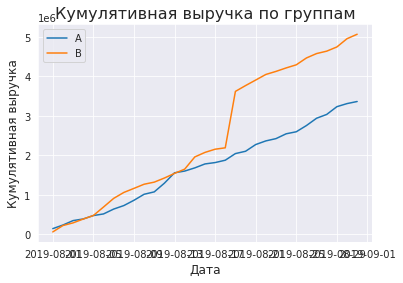

In [18]:
#Создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой для каждой из групп
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'transactions']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'transactions']]
#Строим графики кумулятивной выручки для каждой из групп
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
#Добавим подписи к графикам
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('Кумулятивная выручка по группам')
plt.legend()
plt.show()

Выручка равномерно увеличивается в течение теста, но после 17 августа в группе B произошел либо всплеск числа заказов, либо была произведена аномально дорогие заказы. Данные выбросы необходимо проанализировать.

### <a id='section22'>2.2. Кумулятивный средний чек по группам</a><br>

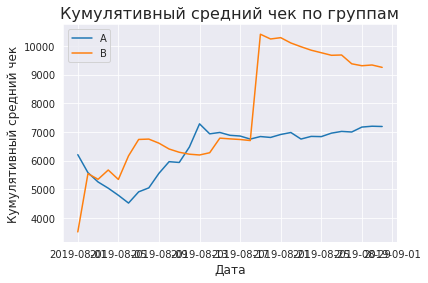

In [19]:
#Построим графики кумулятивного среднего чека по группам, средний чек найдем через отношение всей выручки к числу заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['transactions'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['transactions'], label='B')
#Добавим подписи к графикам
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title('Кумулятивный средний чек по группам')
plt.legend()
plt.show()

Средний чек для обеих групп выравнивался до середины теста, затем средний чек в группе B становится значительно больше среднего чека в группе A. Возможно, резкий всплеск синего графика говорит о том, что в группу B попали крупные заказы. Это сместило реальный средний чек для данной группы выше.

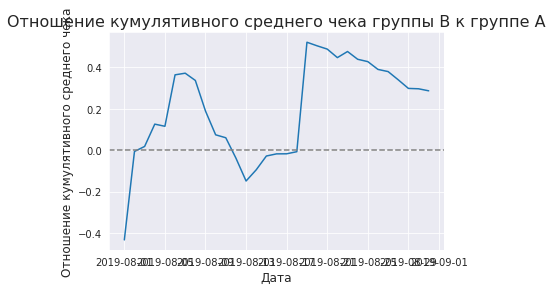

In [20]:
#Для определения относительного изменения кумулятивного среднего чека, соберем данные в одной таблице
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, \
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])
#Построим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.plot(mergedCumulativeRevenue['date'], \
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['transactionsB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['transactionsA']) - 1)
#Добавляем ось X
plt.axhline(y=0, color='grey', linestyle='--')
#Добавим подписи к графику
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего чека')
plt.title('Отношение кумулятивного среднего чека группы B к группе A')
plt.show()

В нескольких точках график различия резко меняется. Вероятно, причиной этого являются крупные заказы и выбросы.

### <a id='section23'>2.3. Кумулятивная конверсия по группам</a><br>

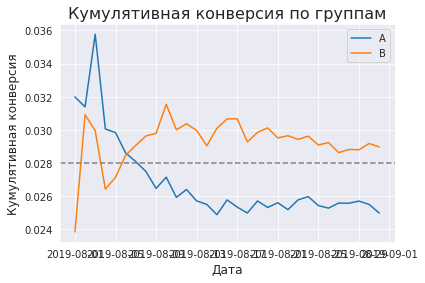

In [21]:
#Посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['transactions']/cumulativeData['visitors']
#Выделим данные для обеих групп в отдельные таблицы
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']
#Построим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
#Добавим подписи к графикам
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.title('Кумулятивная конверсия по группам')
#Добавляем ось X
plt.axhline(y=0.028, color='grey', linestyle='--')
plt.show()

В начале теста группы колебались в районе значения 0.028, но затем конверсия группы B стала больше и зафиксировалась на уровне 0.029, а конверсия группы A просела и также зафиксировалась на уровне 0.026. Кривые стабилизировались в конце теста и это косвенный признак возможности скорого завершения теста.

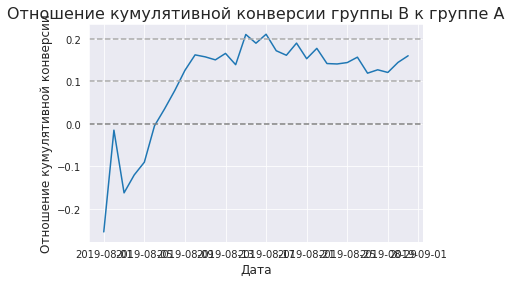

In [22]:
#Объединим данные о кумулятивных конверсиях в одну таблицу
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], \
                                                                            left_on='date', 
                                                                            right_on='date', 
                                                                            how='left', 
                                                                            suffixes=['A', 'B'])
#Построим график относительного различия кумулятивных конверсий
plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']/\
         mergedCumulativeConversions['conversionA'] - 1)
#Добавляем оси X
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=0.1, color='darkgrey', linestyle='--')
plt.axhline(y=0.2, color='darkgrey', linestyle='--')
#Добавим подписи к графику
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивной конверсии')
plt.title('Отношение кумулятивной конверсии группы B к группе A')
plt.show()

В начале теста отношение конверсий не установилось, но затем конверсия группы B стала превышать конверсию группы A и держится в коридоре прироста 12-20% относительно группы A.

### <a id='section24'>2.4. Выбор границы для определения аномальных пользователей</a><br></a><br>

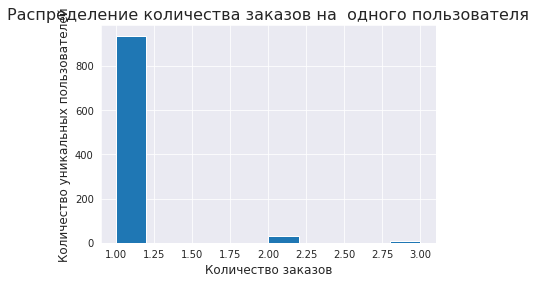

In [23]:
#Сгруппируем таблицу заказов по пользователям
ordersByBuyers = orders.drop(['date', 'revenue'], axis=1).groupby(['group', 'visitorId'], as_index=False)\
                .agg({'transactionId': pd.Series.nunique}).sort_values(by='transactionId', ascending=False)
ordersByBuyers.columns = ['group', 'buyerId', 'transactions']
#Изучим гистограмму распределения
plt.hist(ordersByBuyers['transactions'])
#Добавим подписи к графику
plt.xlabel('Количество заказов')
plt.ylabel('Количество уникальных пользователей')
plt.title('Распределение количества заказов на  одного пользователя')
plt.show()
plt.show()

Большинство посетителей покупают только 1 раз и есть небольшая группа которые покупают чаще.

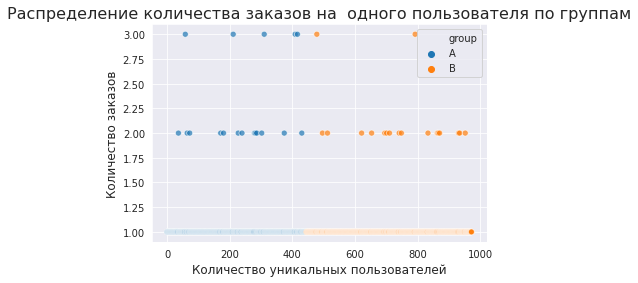

In [24]:
#Построим точечную диаграмму числа заказов на одного посетителя
x_values1 = pd.Series(range(0, len(ordersByBuyers['transactions'])))
sns.scatterplot(x=x_values1, y='transactions', data=ordersByBuyers, alpha=0.7, y_jitter=0.05, hue='group')
#Добавим подписи к графику
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов на  одного пользователя по группам')
plt.show()

Выводы прошлого графика подтвердились: в основном, посетители делают 1 заказ. Посетители, которые делают более 2 заказов распределены между группами хаотично и нет какой-то определенной тенденции.

In [25]:
print(np.percentile(ordersByBuyers['transactions'], [90, 95, 99]))

[1. 1. 2.]


95% пользователей делают не более 1 заказа. Установим это за нижнюю границу

### <a id='section25'>2.5. Выбор границы для определения аномальных заказов</a><br>

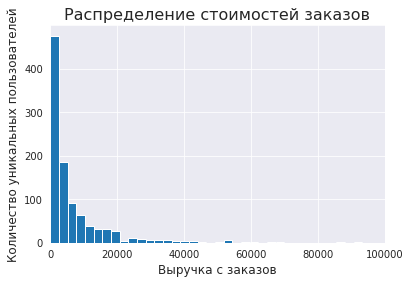

In [26]:
#Изучим гистограмму распределения стоимостей заказов
plt.hist(orders['revenue'], bins=500)
plt.xlim(0, 100000)
#Добавим подписи к графику
plt.xlabel('Выручка с заказов')
plt.ylabel('Количество уникальных пользователей')
plt.title('Распределение стоимостей заказов')
plt.show()

Основная масса транзакций не превышает 20 000 рублей.

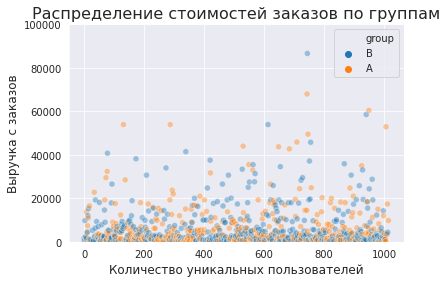

In [27]:
#Построим точечную диаграмму стоимостей заказов
x_values2 = pd.Series(range(0, len(orders['revenue'])))
sns.scatterplot(x=x_values2, y='revenue', data=orders, alpha=0.4, hue='group')
plt.ylim(0, 100000)
#Добавим подписи к графику
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Выручка с заказов')
plt.title('Распределение стоимостей заказов по группам')
plt.show()

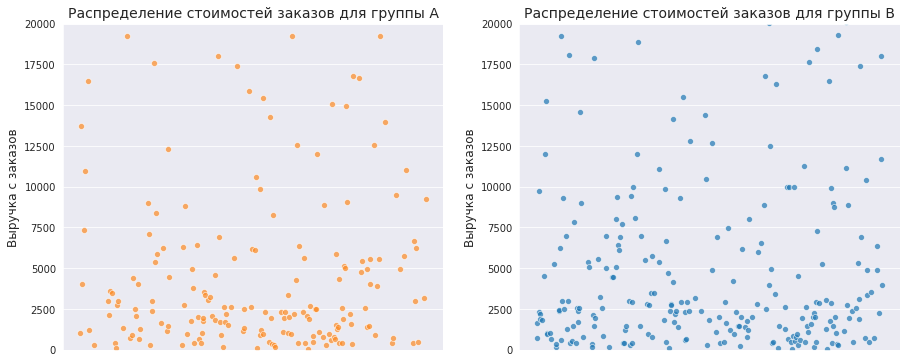

In [28]:
#Построим точечные диаграммы стоимостей заказов по группам с ограничением выручки 20000 рублей
plt.subplots(figsize=(15,6))
#График для группы 'A'
x = pd.Series(range(0, len(orders[orders['group'] == 'A']['revenue'])))
plt.subplot(1, 2, 1)
sns.scatterplot(x=x, y='revenue', data=orders[orders['group'] == 'A'], alpha=0.7, color='#fc8a23')
plt.ylim(0, 20000)
plt.xticks([])
plt.ylabel('Выручка с заказов', fontsize=12)
plt.title('Распределение стоимостей заказов для группы A', fontsize=14)
#График для группы 'B'
x = pd.Series(range(0, len(orders[orders['group'] == 'B']['revenue'])))
plt.subplot(1, 2, 2)
sns.scatterplot(x=x, y='revenue', data=orders[orders['group'] == 'B'], alpha=0.7)
plt.ylim(0, 20000)
plt.xticks([])
plt.ylabel('Выручка с заказов', fontsize=12)
plt.title('Распределение стоимостей заказов для группы B', fontsize=14)
plt.show()

Действительно, заказов дороже 20000 рублей не так много. Эта граница, которую мы определим для аномальных заказов по графику. На первый взгляд, заказы распределены хаотично между группами и нет какой-то определенной тенденции.

In [29]:
#Посчитаем перцентили для определения более точной границы
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


Не более 5% заказов имеют стоимость выше 26785 рублей. Возьмем это за нижнюю границу стоимости.

### <a id='section26'>2.6. Различия в конверсии между группами по «сырым» данным</a><br>

<b>Нулевая гипотеза 1 - Статистически значимых различий в конверсии между группами по "сырым" данным нет. Альтернативная гипотеза 1 - Статистически значимые различия в конверсии между группами по "сырым" данным есть. Уровень статистической значимости  p < 0.05</b>

In [30]:
#Разделим всех посетителей по группам и датам
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
#Найдем количество заказов по группам и датам
ordersADaily = orders[orders['group'] == 'A'][['date', 'transactionId', 'revenue']]\
                    .groupby('date', as_index=False)\
                    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersBDaily = orders[orders['group'] == 'B'][['date', 'transactionId', 'revenue']]\
                    .groupby('date', as_index=False)\
                    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
#Соединим полученные четыре таблицы в одну
daily_data = ordersADaily.merge(ordersBDaily,\
                                left_on='date', 
                                right_on='date', 
                                how='left').merge(visitorsADaily,\
                                                left_on='date', 
                                                right_on='date', 
                                                how='left').merge(visitorsBDaily, \
                                                                 left_on='date', 
                                                                 right_on='date', 
                                                                 how='left')
#Найдем количество заказов, сделанных пользователями разных групп
ordersByUsersA = orders[orders['group'] == 'A']\
            .groupby('visitorId', as_index=False)\
            .agg({'transactionId': pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders[orders['group'] == 'B']\
            .groupby('visitorId', as_index=False)\
            .agg({'transactionId': pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']
#Для каждой из групп сохраним выборку, где каждый элемент число заказов определенного пользователя, в т.ч. ноль. Нули найдем разницей между суммой посетителей и количеством записей о заказах.
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=\
    np.arange(daily_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=\
    np.arange(daily_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)
#Определим, есть ли статистически значимые различия в конверсии между группами. 
alpha = 0.05
result_raw_1 = st.mannwhitneyu(sampleA, sampleB)[1]
print('p-значение: ', '{0:.3f}'.format(result_raw_1))
if result_raw_1 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.006
Отвергаем нулевую гипотезу


Анализ "сырых данных" показал, что в конверсии между группами есть статистически значимые различия и мы отвергаем нулевую гипотезу.

In [31]:
#Сравним прирост конверсии группы B к конверсии группы A через отношение средних в выборках
print('{0:.2%}'.format(sampleB.mean()/sampleA.mean() - 1))

15.98%


Анализ "сырых данных" показал, что относительный прирост конверсии группы B к конверсии группы A равен 15.98%.

### <a id='section27'>2.7. Различия в среднем чеке заказа между группами по «сырым» данным</a><br>

<b>Нулевая гипотеза 2 - Статистически значимых различий в средних чеках заказа между группами по "сырым" данным нет. Альтернативная гипотеза 2 - Статистически значимые различия  в средних чеках заказа между группами по "сырым" данным есть. Уровень статистической значимости  p < 0.05</b>

In [32]:
##Определим, есть ли статистически значимые различия в средних чеках между группами. Нулевая гипотеза - средние чеки равны. Альтернативная гипотеза - средние чеки не равны.
alpha = 0.05
result_raw_2 = st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]
print('p-значение: ', '{0:.3f}'.format(result_raw_2))
if result_raw_2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.415
Не получилось отвергнуть нулевую гипотезу


Анализ "сырых данных" показал, что в средних чеках между группами нет статистически значимых различий и мы не можем отвергнуть нулевую гипотезу.

In [33]:
#Определим относительное различие среднего чека
print('{0:.2%}'.format(orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean() - 1))

28.66%


Анализ "сырых данных" показал, что относительный прирост среднего чека группы B к среднему чеку группы A равен 28.66%. Разница значительная, посмотрим какой результат покажут "очищенные данные".

### <a id='section28'>2.8. Различия в конверсии между группами по «очищенным» данным</a><br>

<b>Нулевая гипотеза 3 - Статистически значимых различий в конверсии между группами по "очищенным" данным нет. Альтернативная гипотеза 3 - Статистически значимые различия в конверсии между группами по "очищенным" данным есть. Уровень статистической значимости  p < 0.05</b>

In [34]:
#Найдем посетителей с большим количеством заказов
VisitorsWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['visitorId'],\
                                    ordersByUsersB[ordersByUsersB['orders'] > 1]['visitorId']], axis=0)
#Найдем посетителей с дорогими заказами
VisitorsWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
#Соединим таблицы и удалим дубликаты
abnormalVisitors = pd.concat([VisitorsWithManyOrders, VisitorsWithExpensiveOrders], axis=0)\
                                    .drop_duplicates()\
                                    .sort_values()
print(abnormalVisitors.head(5))
print(abnormalVisitors.shape)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: uint64
(86,)


Мы получили 86 аномальных пользователя. Исключим их действия, создав отфильтрованные выборки.

In [35]:
#Создадим отфильтрованные выборки
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']\
                            .isin(abnormalVisitors))]['orders'],pd.Series(0, index=\
                            np.arange(daily_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),\
                                                                                    name='orders')], axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']\
                            .isin(abnormalVisitors))]['orders'],pd.Series(0, index=\
                            np.arange(daily_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),\
                                                                                    name='orders')], axis=0)
#Определим, есть ли статистически значимые различия в конверсии между группами.  Нулевая гипотеза - конверсии равны. Альтернативная гипотеза - конверсии не равны.
alpha = 0.05
result_clean_1 = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print('p-значение: ', '{0:.3f}'.format(result_clean_1))
if result_clean_1 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.008
Отвергаем нулевую гипотезу


p-значение немного увеличилось. Анализ "очищенных данных" показал, что в конверсии между группами есть статистически значимые различия и мы отвергаем нулевую гипотезу. Как и в случае с "сырыми данными", статистическая значимость достигнута. Это означает, что сегмент B значительно лучше сегмента A.

In [36]:
#Сравним прирост конверсии группы B к конверсии группы A через отношение средних в выборках
print('{0:.2%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean() - 1))

17.39%


Анализ "очищенных данных" показал, что относительный прирост конверсии группы B к конверсии группы A равен 17.39%. Этот результат почти на 9% больше в относительном выражении, чем по итогам анализа "сырых данных".

### <a id='section29'>2.9. Различия в среднем чеке заказа между группами по «очищенным» данным</a><br>

<b>Нулевая гипотеза 4 - Статистически значимых различий в средних чеках заказа между группами по "очищенным" данным нет. Альтернативная гипотеза 4 - Статистически значимые различия  в средних чеках заказа между группами по "очищенным" данным есть. Уровень статистической значимости  p < 0.05</b>

In [37]:
##Определим, есть ли статистически значимые различия в средних чеках между группами. Нулевая гипотеза - средние чеки равны. Альтернативная гипотеза - средние чеки не равны.
alpha = 0.05
result_clean_2 = st.mannwhitneyu(orders[np.logical_and(
                                    orders['group'] == 'A',
                                    np.logical_not(orders['visitorId'].isin(abnormalVisitors)))]['revenue'],
                                 orders[np.logical_and(
                                    orders['group'] == 'B',
                                    np.logical_not(orders['visitorId'].isin(abnormalVisitors)))]['revenue'])[1]
print('p-значение: ', '{0:.3f}'.format(result_clean_2))
if result_clean_2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.364
Не получилось отвергнуть нулевую гипотезу


Анализ "очищенных данных" показал, что статистическая значимость различий среднего чека заказа не достигнута. Это означает, что удаление выбросов не помогло.

In [38]:
#Определим относительное различие среднего чека
print('{0:.2%}'.format(orders[np.logical_and(orders['group']=='B',\
                              np.logical_not(orders['visitorId'].isin(abnormalVisitors)))]['revenue'].mean()/\
                       orders[np.logical_and(orders['group']=='A',\
                              np.logical_not(orders['visitorId'].isin(abnormalVisitors)))]['revenue'].mean() - 1))

-3.37%


Анализ "очищенных данных" показал, что относительный прирост конверсии группы B к конверсии группы A стал отрицателен и равен -3.37%. Это означает, что средний чек группы А в конце немного вырвался вперед, но расхождение очень незначительное.

## <a id='section3'>3. Принятие решения по итогам A/B теста</a><br>

#### Выводы

1. Имеются статистически значимые различия конверсии между группами и по "сырым" и по "очищенным данным. Относительный прирост конверсии группы B к конверсии группы A равен 17.39% - это хороший результат
2. Статистическая значимость различия среднего чека заказов не достигнута ни по "сырым", ни по "очищенным данным". Более того, после фильтрации аномалий отношение средних чеков стало совсем незначительным (3.37% в пользу группы 'A')

Это может означать, что посетители из группы 'B' более замотивированы к покупке, но по какой-то причине они приносят чуть меньше выручки, чем посетители из группы 'A'. То есть увеличив конверсию, мы, возможно, понизили доходность. Вероятно, проблема в рекламном сообщении / источнике трафика/ таргетинге/ демографических характеристиках посетителей / качестве выборки или других причинах. 

#### Решение

Остановить тест и признать его неуспешным. На основе базовой гипотезы создать несколько новых тестов, в которых будет исследовано влияние дополнительных факторов на базовую гипотезу.